# Capstone Project
- [Problem Statement](#Problem-Statement)
- [Executive Summary](#Executive-Summary)
- [Import and clean Train & Test data](#Import-and-clean-Train-&-Test-data)
    - [Splitting into country, state, city](#Splitting-into-country,-state,-city)
    - [Converting Salary Ranges](#Converting-Salary-Ranges)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Preprocessing](#Preprocessing)
- [Modelling](#Modelling)
    - [TFIDF + Multi-nomial Naive Bayes Model](#TFIDF-+-Multi-nomial-Naive-Bayes-Model)
    - [TFIDF + Logistic Regression Model](#TFIDF-+-Logistic-Regression-Model)
- [Using Non-words for modelling](#Using-Non-words-for-modelling)
    - [Logistic Regression Model](#Logistic-Regression-Model)
- [Voting Classifier](#Voting-Classifier)
- [Conclusions and Recommendations](#Conclusions-and-Recommendations)

# Problem Statement:
We are living in unprecedented times due to COVID-19 pandemic hurting economies in every continent. Unemployment rates are increasing every single day with the United States(US) reporting around 42 million people applied for unemployment benefits, which is the highest recorded in its long history, millions have been furloughed in the United Kingdom, and thousands have been laid off around the world. In the US, scammers uses the job listing to get job seekers to provide personal information, including their Social Security number, credit card information, and bank account information. These information is then used to access your bank account or your credit cards and to steal your identity.

# Executive Summary:
The Employment Scam Aegean Dataset (EMSCAD) is a publicly available dataset containing 17,880 real-life job ads that aims at providing a clear picture of the Employment Scam problem to the research community and can act as a valuable testbed for scientists working on the field. The first publication is available online by MDPI Future Internet Journal.

EMSCAD records were manually annotated and classified into two categories. More specifically, the dataset contains 17,014 legitimate and 866 fraudulent job ads published between 2012 to 2014.

We will build a model capable of classifying fake job and real job posts. We will make use of both the 'words' and 'non-words' features, create 3 models and run them through a voting classifer to obtain the final prediction.


# Import & Clean Train and Test data

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords # Import the stopword list
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud

from collections import Counter

%matplotlib inline

In [99]:
# Read in the input file
train_df = pd.read_csv('fake_job_postings.csv')

In [100]:
# Define function for basic eda

def data_explore(df):
    #First two rows
    print("First two rows of data:")
    display(df.head(2))
    print()
    print("Last two rows of data:")
    display(df.tail(2))
    print()
    # Print shape of dataframe
    print(f"Shape: {df.shape}")
    print()
    # Print datatypes
    print("Columns & Datatypes: ")
    df.info()
    print()
    # Check for null values
    print("Null values:")
    if df.isnull().values.any() == False:
        print("None in Dataframe.")
    else:
        for col in df:
            print(f"{col}:{df[col].isnull().sum()}")
    print()
    # Count of distinct values
    print("Count of Unique values (by Columns)")
    for col in df:
        print(f"{col}:{len(df[col].unique().tolist())}")
    print()
    # Inform if there are duplicates, if any
    if df.duplicated(subset=None, keep='first').any() == False:
        print("No duplicates present.")
    else:
        dup = df[df.duplicated(subset=None, keep='first')]
        print(f"{len(dup)} duplicates in {len(df)} rows.")

In [101]:
# Basic eda checking for null values an duplicate rows
data_explore(train_df)

First two rows of data:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0



Last two rows of data:


,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
17878,17879,Graphic Designer,"NG, LA, Lagos",NaN,NaN,NaN,Nemsia Studios is looking for an experienced v...,1. Must be fluent in the latest versions of Co...,Competitive salary (compensation will be based...,0,0,1,Contract,Not Applicable,Professional,Graphic Design,Design,0
17879,17880,Web Application Developers,"NZ, N, Wellington",Engineering,NaN,Vend is looking for some awesome new talent to...,Who are we?Vend is an award winning web based ...,We want to hear from you if:You have an in-dep...,NaN,0,1,1,Full-time,Mid-Senior level,NaN,Computer Software,Engineering,0



Shape: (17880, 18)

Columns & Datatypes: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17880 entries, 0 to 17879
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               17880 non-null  int64 
 1   title                17880 non-null  object
 2   location             17534 non-null  object
 3   department           6333 non-null   object
 4   salary_range         2868 non-null   object
 5   company_profile      14572 non-null  object
 6   description          17879 non-null  object
 7   requirements         15185 non-null  object
 8   benefits             10670 non-null  object
 9   telecommuting        17880 non-null  int64 
 10  has_company_logo     17880 non-null  int64 
 11  has_questions        17880 non-null  int64 
 12  employment_type      14409 non-null  object
 13  required_experience  10830 non-null  object
 14  required_education   9775 non-null   object
 15  industry  

We will take a look at the data dictionary.

| Column titles | Description |
|---|---|
| title | The title of the job ad entry. | 
| location | Geographical location of the job ad. | 
| department | Corporate department (e.g. sales). | 
| salary_range | Indicative salary range (e.g. $50,000-$60,000) |
| company_profile | A brief company description. |
| description | The details description of the job ad. |
| requirements | Enlisted requirements for the job opening. |
| benefits | Enlisted offered benefits by the employer. |
| telecommuting | True for telecommuting positions. |
| has_company_logo | True if company logo is present. |
| has_questions | True if screening questions are present. |
| employment_type | Full-type, Part-time, Contract, etc. |
| required_experience | Executive, Entry level, Intern, etc |
| required_education | Doctorate, Master’s Degree, Bachelor, etc. |
| industry | Automotive, IT, Health care, Real estate, etc. |
| function | Consulting, Engineering, Research, Sales etc. |
| fraudulent | target - Classification attribute. |




In [102]:
# Use this method to see all null values in columns
null_columns = train_df.columns[train_df.isnull().any()]
train_df[null_columns].isnull().sum()

location                 346
department             11547
salary_range           15012
company_profile         3308
description                1
requirements            2695
benefits                7210
employment_type         3471
required_experience     7050
required_education      8105
industry                4903
function                6455
dtype: int64

From the data dictionary, the missing values are all 'object' type. We will fill the missing values with string 'NA'.

In [103]:
# Fill missing values with string 'NA'
train_df.fillna('NA', inplace=True)

In [104]:
# Check for null values
train_df[null_columns].isnull().sum()

location               0
department             0
salary_range           0
company_profile        0
description            0
requirements           0
benefits               0
employment_type        0
required_experience    0
required_education     0
industry               0
function               0
dtype: int64

In [105]:
# Remove the spaces between the words

train_df_copy = train_df.copy()

for count, elem in enumerate(train_df_copy['department']):
    train_df['department'][count].strip()

## Splitting into country, state, city

We will create new columns for country, state and city for further analysis

In [106]:
location = train_df['location'].copy()
location_split = list(location.str.split(', ').values)

# Check if 'NA','' or is a digit, replace with 'Unspecified'
for count, loc in enumerate(location_split):
    
    if loc==['NA']:
        location_split[count] = ['Unspecified'] * 3
    else:
        for elem_count, elem in enumerate(loc):
            if elem == '':
                loc[elem_count] = 'Unspecified'
            elif elem.isdigit():
                loc[elem_count] = 'Unspecified'

# Join city names if more than 2 words
for count2, loc2 in enumerate(location_split):
    if len(loc2) > 3:
        location_split[count2] = loc2[:2] + [', '.join(loc2[2:])]
    elif len(loc2) < 3:
        location_split[count2] += ['Unspecified'] * 2

# Create new features 'country', 'state' and 'city' into train_df
data_location = pd.DataFrame(location_split, columns=['country', 'state', 'city'])
train_df= pd.concat([train_df, data_location], axis=1)
train_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city
0,1,Marketing Intern,"US, NY, New York",Marketing,NA,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NA,0,...,0,Other,Internship,NA,NA,Marketing,0,US,NY,New York
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NA,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,0,Full-time,Not Applicable,NA,Marketing and Advertising,Customer Service,0,NZ,Unspecified,Auckland
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NA,NA,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NA,0,...,0,NA,NA,NA,NA,NA,0,US,IA,Wever
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NA,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington
4,5,Bill Review Manager,"US, FL, Fort Worth",NA,NA,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth


## Converting Salary Ranges

We change the salary ranges from string to int and create columns 'min_salary' and 'max_salary' for further analysis

In [107]:
salary_range = train_df['salary_range'].copy()

salary_range_sep = list(salary_range.str.split('-').values)

# Set 'NA' to range 0-0, if only 1 range value - lower = upper range and if not digit, set range to 0 - 0
for count, salary in enumerate(salary_range_sep):
    #print(salary)
    if (salary == ['NA']):
        salary_range_sep[count] = ['0','0']
    elif (len(salary)<2):
        salary_range_sep[count] = salary * 2
    else:
        for elem in salary:
            if (elem.isdigit()==False):
                salary_range_sep[count] = ['0','0']


# Convert lower and upper range into int
min_value = []
max_value = []

for salary2 in salary_range_sep:
    for count2, elem2 in enumerate(salary2):
        if (count2==0):
            min_value.append(int(elem2))            
        else:
            max_value.append(int(elem2))
              
# Create new features min_salary and max_salary into train_df
data_salary_range = {'min_salary': min_value, 'max_salary': max_value}
dsr_df = pd.DataFrame(data_salary_range)
train_df = pd.concat([train_df, dsr_df], axis=1)

In [108]:
train_df.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,...,required_experience,required_education,industry,function,fraudulent,country,state,city,min_salary,max_salary
0,1,Marketing Intern,"US, NY, New York",Marketing,NA,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NA,0,...,Internship,NA,NA,Marketing,0,US,NY,New York,0,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NA,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,...,Not Applicable,NA,Marketing and Advertising,Customer Service,0,NZ,Unspecified,Auckland,0,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NA,NA,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NA,0,...,NA,NA,NA,NA,0,US,IA,Wever,0,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NA,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,...,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,0,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NA,NA,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,...,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,0,0


# Exploratory Data Analysis

In [109]:
# Filter the fraudulent job posts
fraud_posts_df = train_df[train_df['fraudulent']==1]

In [110]:
# Check the shape
fraud_posts_df.shape

(866, 23)

In [111]:
# Filter the real job posts
real_posts_df = train_df[train_df['fraudulent']==0]

In [112]:
# Check the shape
real_posts_df.shape

(17014, 23)

In [113]:
# Function to plot and compare the top 10 variables between fake and real of a category
def compare_plot(topic):
    
    top_fraud = fraud_posts_df[topic].value_counts(normalize=True)[:10]
    top_real = real_posts_df[topic].value_counts(normalize=True)[:10]
    
    if(top_fraud.index[0]=='NA'):
        top_fraud = fraud_posts_df[topic].value_counts(normalize=True)[1:11]
    if(top_real.index[0]=='NA'):
        top_real = real_posts_df[topic].value_counts(normalize=True)[1:11]
    
    plt.figure(figsize=(12,6))
    
    ax1 = plt.subplot(2,1,1)
    sns.barplot(top_fraud.values, top_fraud.index)
    plt.title('Top ' + str(len(top_fraud)) + ' fake jobs ' + topic)
    plt.ylabel('Job ' + topic, fontsize=12)
    plt.xlabel('Percentage of jobs post ' + topic, fontsize=12);
    
    ax2 = plt.subplot(2,1,2)
    sns.barplot(top_real.values, top_real.index)
    plt.title('Top ' + str(len(top_real)) + ' real jobs ' + topic)
    plt.ylabel('Job ' + topic, fontsize=12)
    plt.xlabel('Precentage of jobs post ' + topic, fontsize=12);
    
    plt.subplots_adjust(left=None, bottom=1, right=None, top=2.4, wspace=None, hspace=None)

In [114]:
# Function to plot and compare the count between fake and real of a category 
def compare_plot2(topic):
    plt.figure(figsize=(12,6))
    
    ax1 = plt.subplot(2,2,1)
    sns.countplot(fraud_posts_df[topic])
    plt.title('Fake posts: No. of ' + topic)
    
    ax2 = plt.subplot(2,2,2)
    sns.countplot(real_posts_df[topic])
    plt.title('Real posts: No. of ' + topic)

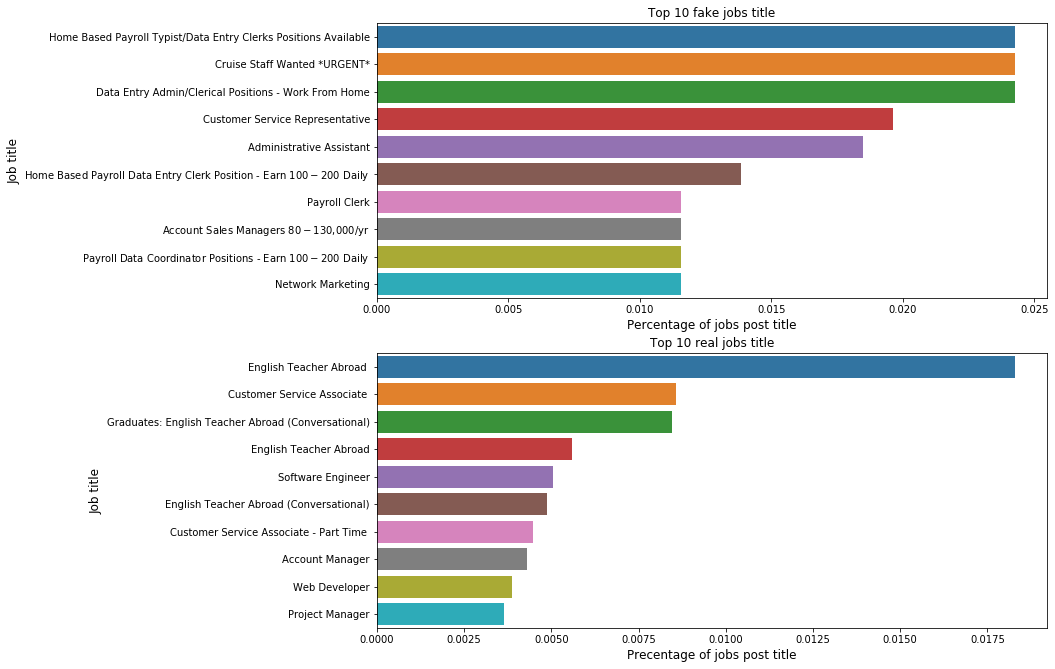

In [115]:
# Top 10 of job titles
compare_plot('title')

We can see that the scammers are targetting home-based and data entry positions. Where as for real job postings, we can see that teaching abroad positions are quite popular. Furthermore, fake job titles seem to put the amount of wage you can earn as compared to real job titles.

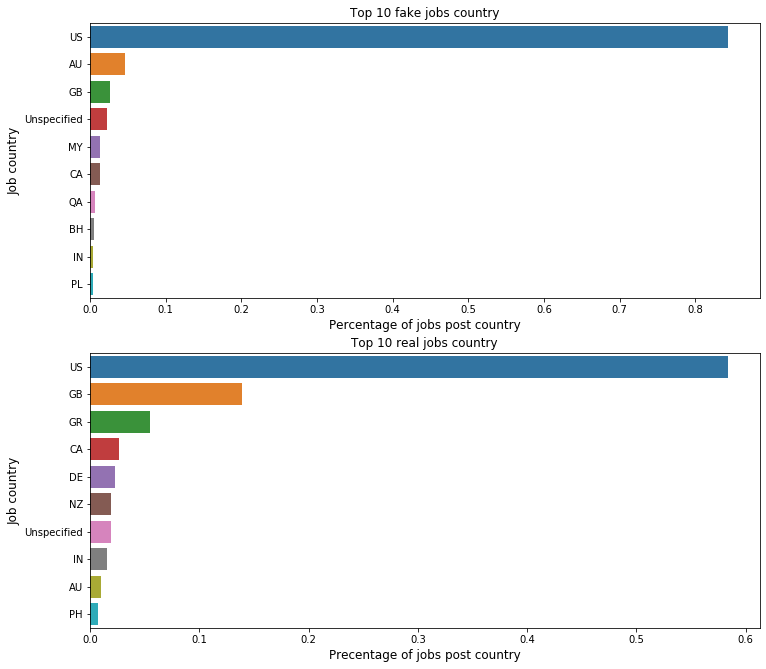

In [116]:
# Top 10 of job posts in country
compare_plot('country')

We can see that the United States is the country that the scammers target the most.

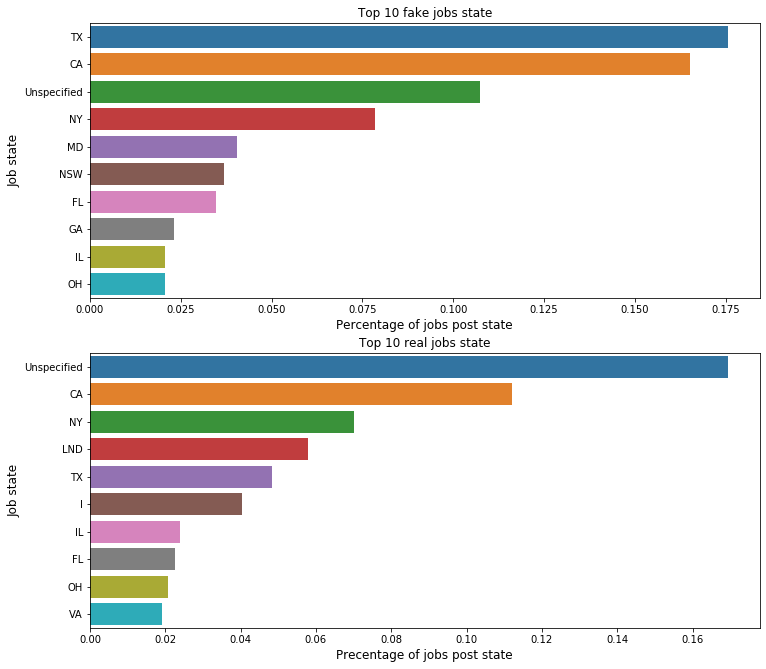

In [117]:
# top 10 jobs posts in states
compare_plot('state')

We can see the US states of Texas, California, New York, Maryland, Florida, Georgia, Illinois, Ohio being a location of target by the scammers. Exception is New South Wales which is in Australia.

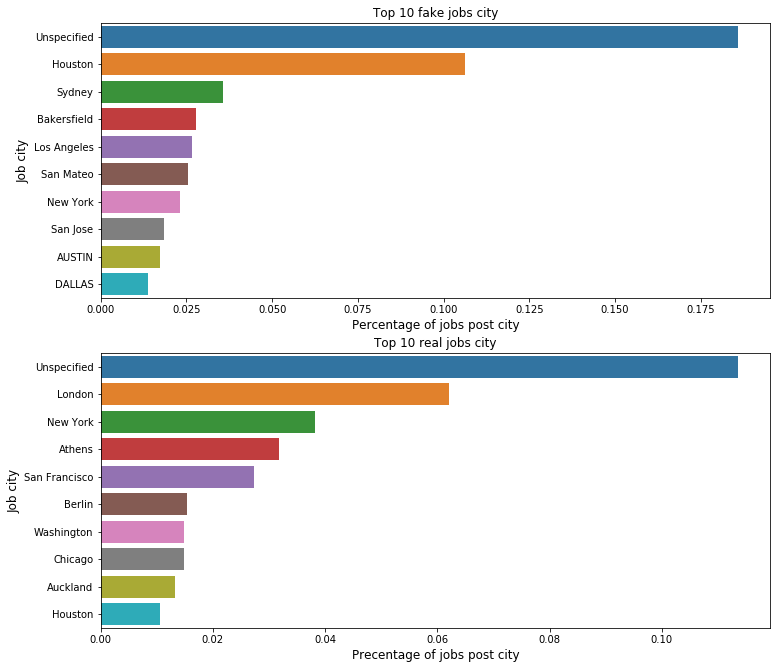

In [118]:
# top 10 jobs posts in cities
compare_plot('city')

We can see majority of the cities in the fake jobs post belong to the US. 

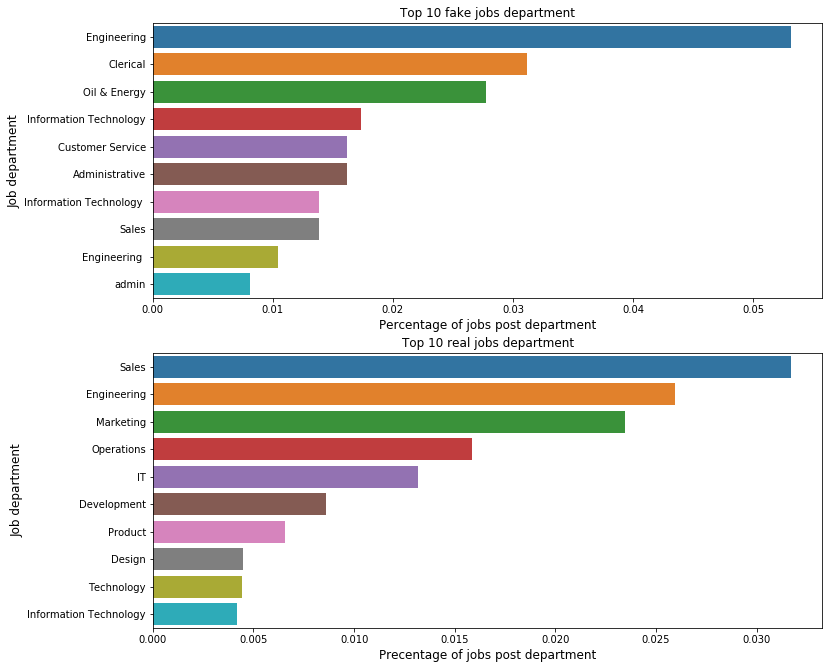

In [119]:
# top 10 jobs posts in departments
compare_plot('department')

Interestingly, we see engineering and oil & energy as the top 2 job departments that the scammers are targeting. 

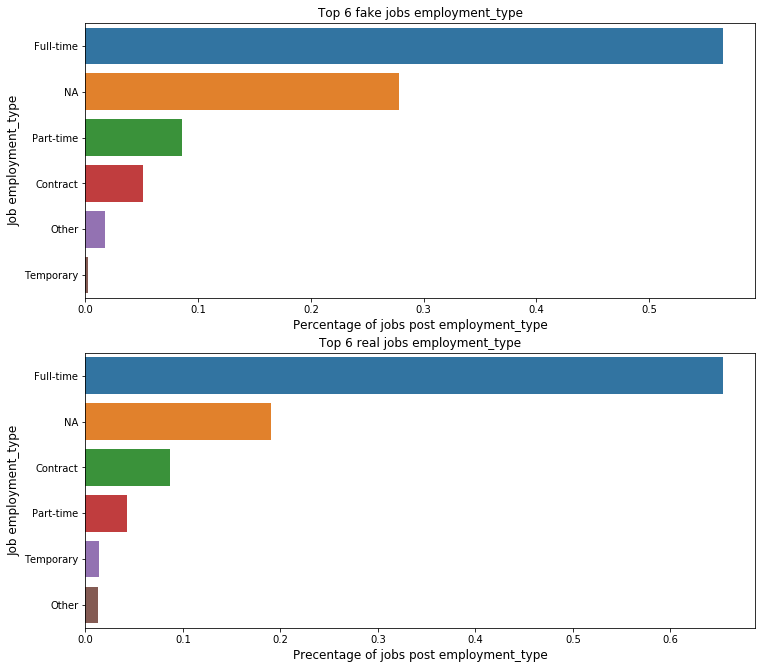

In [120]:
# top 10 jobs posts in employment type
compare_plot('employment_type')

We can see that the scammers are mostly targetting full-time positions

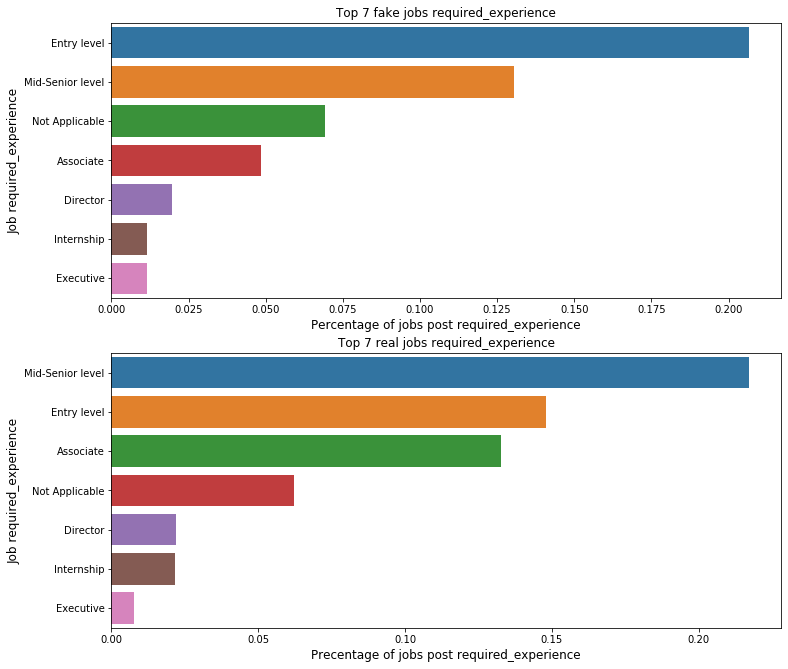

In [121]:
# top 7 jobs posts in job required_experience
compare_plot('required_experience')

The scammers are targeting mostly entry level positions as well as mid-senior level positions. 

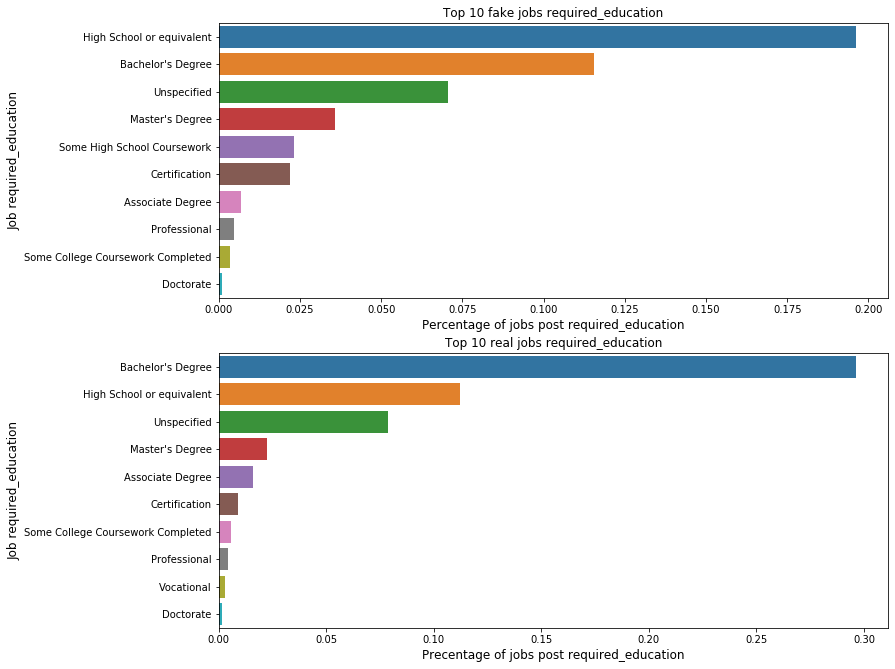

In [122]:
# top 10 jobs posts in job required education
compare_plot('required_education')

The scammers are following the market's position of hiring at least a "high school or equivalent or a Bachelor's Degree" education holder.

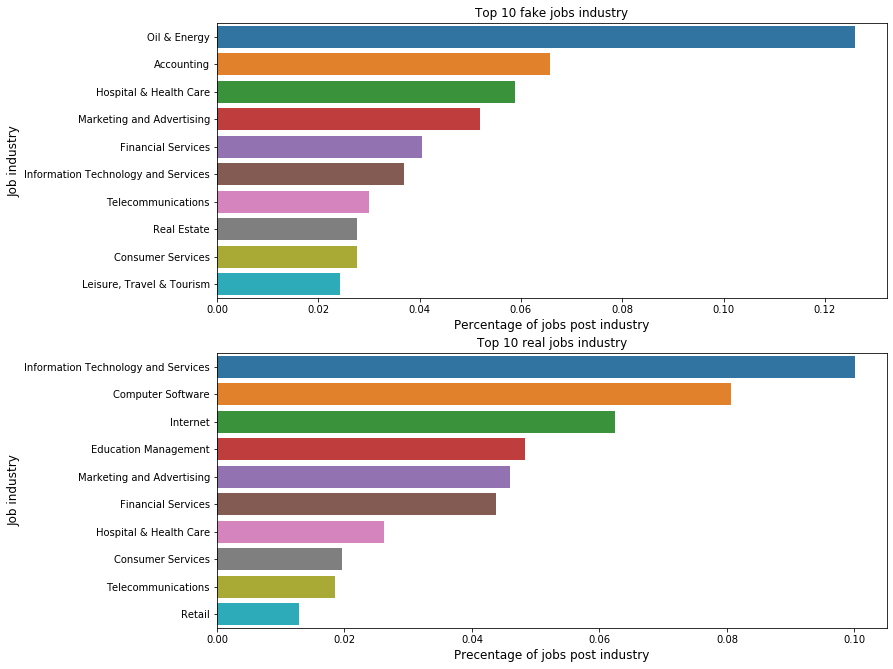

In [123]:
# top 10 jobs posts in industry
compare_plot('industry')

The scammers are targetting oil and energy and accounting industries. Oil and energy jobs are in demand due high oil prices at that time which leads to increase production and manpower. Accounting due to the job nature of being able to work from home. <br>
<br>
Source for high oil prices between 2012-2014:
https://www.macrotrends.net/2516/wti-crude-oil-prices-10-year-daily-chart

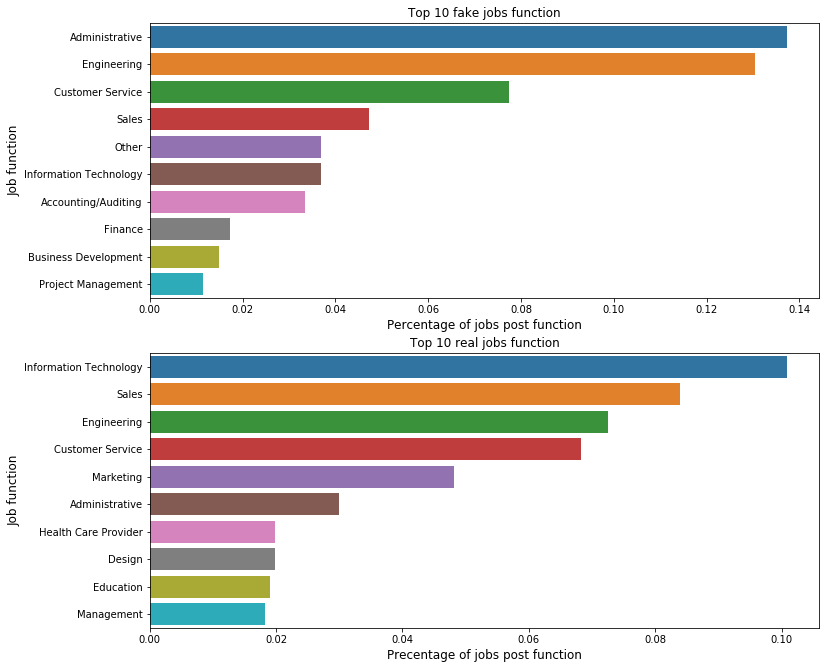

In [124]:
# top 10 jobs posts in function
compare_plot('function')

Administrative functions due to data entry and accounting. Engineering jobs may be related to the oil & energy sector.

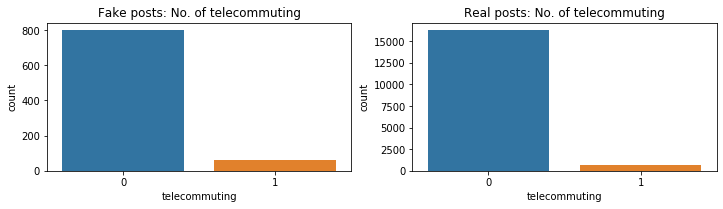

In [125]:
compare_plot2('telecommuting')

There does not seem to have a difference between fake job posts and real job posts on telecommuting.

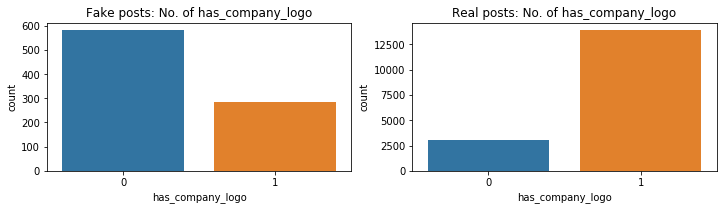

In [126]:
compare_plot2('has_company_logo')

It seems that most fake job posts do not put the company logo as compared to real job posts.

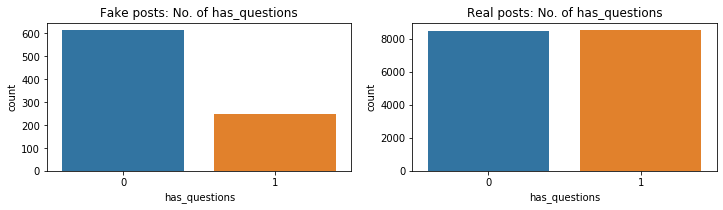

In [127]:
compare_plot2('has_questions')

There is about a 65-35 split on fake job posts posting screening questions as compared to real job posts having a 50-50 split.

In [128]:
# Add new stop words
stop_w = stopwords.words('english')
newStopWords = ['NA','na']
stop_w.extend(newStopWords)

In [129]:
# Check stop words list
stop_w

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [130]:
# Function to plot WordCloud

def plot_WC(fake_str, real_str, topic1, topic2):
    
    stops = set(stop_w)

    wc_fake = WordCloud(max_words= 100,
                      width = 744,
                      height = 544,
                      background_color ='white',
                      stopwords=stops,
                      contour_width=3,
                      contour_color='steelblue',
                      min_font_size = 10).generate(fake_str)

    wc_real = WordCloud(max_words= 100,
                      width = 744,
                      height = 544,
                      background_color ='white',
                      stopwords=stops,
                      contour_width=3,
                      contour_color='steelblue',
                      min_font_size = 10).generate(real_str)
    
    # plot the WordCloud image
    plt.figure(figsize = (17, 17))
    #plt.title("WordCloud image for r/Rom")
    #plt.imshow(wc_rom);
    
    ax1 = plt.subplot(2,2,1)
    ax1.imshow(wc_fake);
    plt.title("WordCloud image for " + topic1)
    
    ax2 = plt.subplot(2,2,2)
    ax2.imshow(wc_real);
    plt.title("WordCloud image for " + topic2)


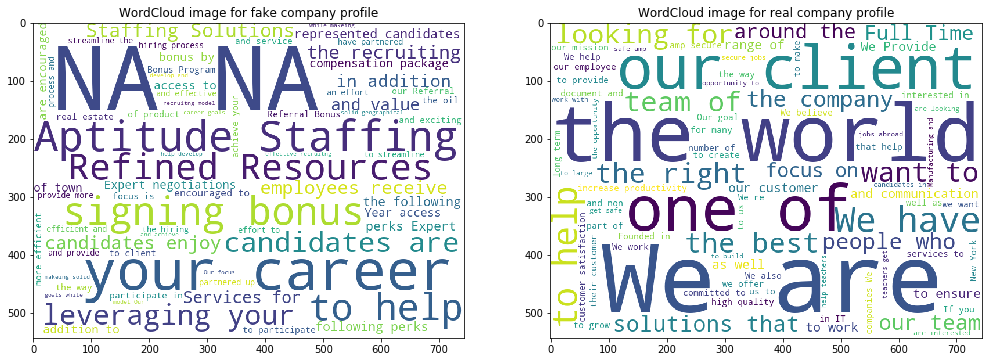

In [131]:
# join up all the strings to be procressed in WordCloud
fake_co_profile = ' '.join(map(str, fraud_posts_df['company_profile']))
real_co_profile = ' '.join(map(str, real_posts_df['company_profile'])) 

plot_WC(fake_co_profile, real_co_profile, 'fake company profile', 'real company profile')

We will need to add 'NA' into our stop words

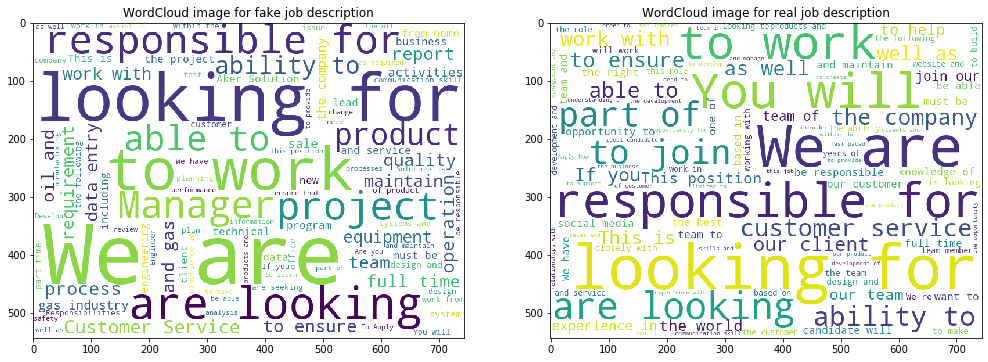

In [132]:
# join up all the strings to be procressed in WordCloud
fake_description = ' '.join(map(str, fraud_posts_df['description']))
real_description = ' '.join(map(str, real_posts_df['description']))

plot_WC(fake_description, real_description, 'fake job description', 'real job description')

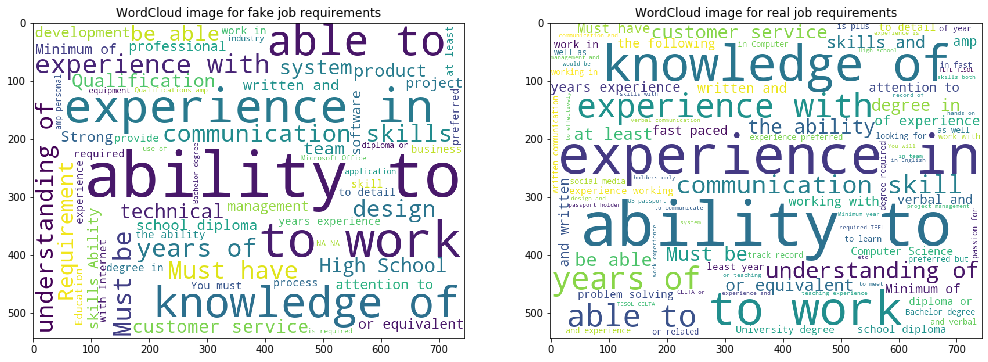

In [133]:
# join up all the strings to be procressed in WordCloud
fake_requirements = ' '.join(map(str, fraud_posts_df['requirements']))
real_requirements = ' '.join(map(str, real_posts_df['requirements']))

plot_WC(fake_requirements, real_requirements, 'fake job requirements', 'real job requirements')

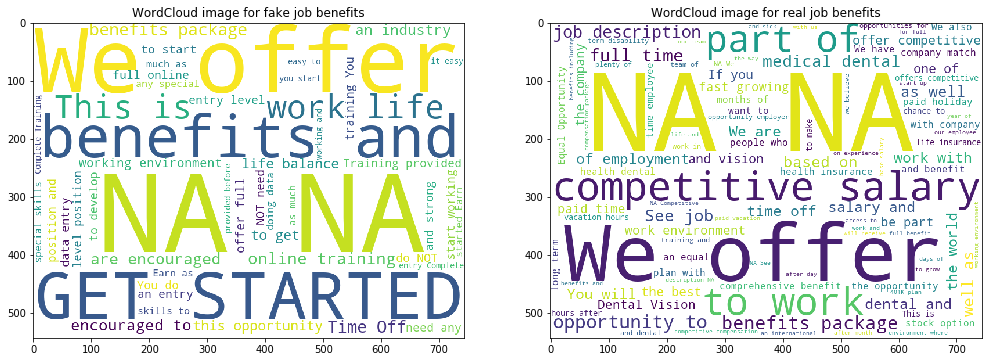

In [134]:
# join up all the strings to be procressed in WordCloud
fake_benefits = ' '.join(map(str, fraud_posts_df['benefits']))
real_benefits = ' '.join(map(str, real_posts_df['benefits']))

plot_WC(fake_benefits, real_benefits, 'fake job benefits', 'real job benefits')

We will need to add 'NA' into our stop words.


We will combined columns for 'title', 'company_profile', 'description', 'requirements' and 'benefits'.

In [135]:
# Combine columns into one column 'word_features'
train_df['word_features'] = train_df['title'] + ' ' + train_df['company_profile'] + ' ' + train_df['description'] + ' '\
                        + train_df['requirements'] + ' ' + train_df['benefits']

In [136]:
# Check one entry
train_df['word_features'][0]

"Marketing Intern We're Food52, and we've created a groundbreaking and award-winning cooking site. We support, connect, and celebrate home cooks, and give them everything they need in one place.We have a top editorial, business, and engineering team. We're focused on using technology to find new and better ways to connect people around their specific food interests, and to offer them superb, highly curated information about food and cooking. We attract the most talented home cooks and contributors in the country; we also publish well-known professionals like Mario Batali, Gwyneth Paltrow, and Danny Meyer. And we have partnerships with Whole Foods Market and Random House.Food52 has been named the best food website by the James Beard Foundation and IACP, and has been featured in the New York Times, NPR, Pando Daily, TechCrunch, and on the Today Show.We're located in Chelsea, in New York City. Food52, a fast-growing, James Beard Award-winning online food community and crowd-sourced and cu

In [137]:
# Function to clean the words

def post_to_words(post):
    # Function to clean the words
    # The input is a single string 
    # the output is a single string          
   
    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", post)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stop_w)
    
    # Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    # lemmatize similar words
    lemmatizer = WordNetLemmatizer()
    meaningful_words2 = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words2))

In [138]:
# Filter USA records and clean the words

clean_fake_words = []
clean_real_words = []

for count, elem in enumerate(train_df['word_features']):
    if ((train_df['fraudulent'][count]==1) & (train_df['country'][count]=='US')):
        clean_fake_words.append(post_to_words(elem))
    elif ((train_df['fraudulent'][count]==0) & (train_df['country'][count]=='US')):
        clean_real_words.append(post_to_words(elem))

In [139]:
len(clean_fake_words)

730

In [140]:
# Function to get top unigram counts

def get_top_n_words(corpus, n=None):
    
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    
    return words_freq[:n]

In [141]:
get_top_n_words(clean_fake_words, n=20)

[('work', 1638),
 ('experience', 1409),
 ('service', 1160),
 ('skill', 1051),
 ('customer', 1024),
 ('amp', 957),
 ('company', 877),
 ('team', 869),
 ('product', 859),
 ('position', 842),
 ('project', 803),
 ('time', 747),
 ('business', 699),
 ('system', 653),
 ('year', 649),
 ('ability', 621),
 ('management', 610),
 ('engineering', 609),
 ('data', 585),
 ('industry', 582)]

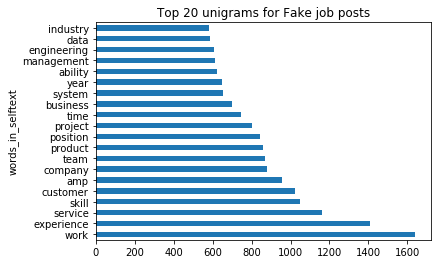

In [148]:
# display top unigrams and corresponding frequecy for Fake job posts
common_words_1 = get_top_n_words(clean_fake_words, 20)

df1 = pd.DataFrame(common_words_1, columns = ['words_in_selftext' , 'count'])
df1.groupby('words_in_selftext').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', title='Top 20 unigrams for Fake job posts');

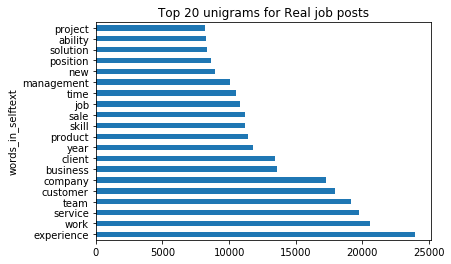

In [149]:
# display top unigrams and corresponding frequecy for Real job posts
common_words_0 = get_top_n_words(clean_real_words, 20)

df1 = pd.DataFrame(common_words_0, columns = ['words_in_selftext' , 'count'])
df1.groupby('words_in_selftext').sum()['count'].sort_values(ascending=False).plot(
    kind='barh', title='Top 20 unigrams for Real job posts');

Not much information can be seen looking at top 20 unigrams.

In [47]:
# Function to get top bigram counts

def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) 
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:20]

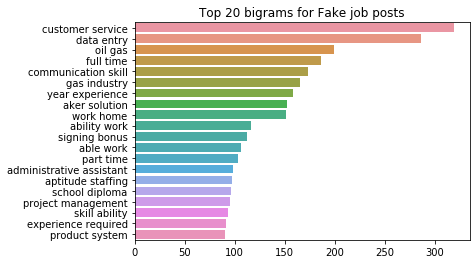

In [150]:
# display top bigrams and corresponding frequecy for Fake job posts
top_n_bigrams_1=get_top_ngram(clean_fake_words,2)[:20]
x,y=map(list,zip(*top_n_bigrams_1))
sns.barplot(x=y,y=x)
plt.title('Top 20 bigrams for Fake job posts');

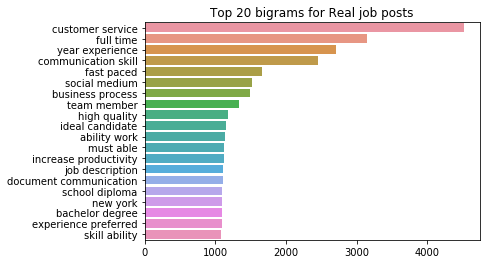

In [151]:
# display top bigrams and corresponding frequecy for Real job posts
top_n_bigrams_1=get_top_ngram(clean_real_words,2)[:20]
x,y=map(list,zip(*top_n_bigrams_1))
sns.barplot(x=y,y=x)
plt.title('Top 20 bigrams for Real job posts');

We can see data entry, oil gas, gas industry, work home are some key identifiers

In [50]:
# add new stop words
newStopWords = ['amp']
stop_w.extend(newStopWords)

In [51]:
features_df = train_df.copy()

In [52]:
features_df.drop(labels=['job_id', 'title', 'location', 'salary_range','company_profile', 'description', 'requirements', 'benefits'], axis=1, inplace=True)

In [53]:
features_df.head()

,department,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent,country,state,city,min_salary,max_salary,word_features
0,Marketing,0,1,0,Other,Internship,NA,NA,Marketing,0,US,NY,New York,0,0,"Marketing Intern We're Food52, and we've creat..."
1,Success,0,1,0,Full-time,Not Applicable,NA,Marketing and Advertising,Customer Service,0,NZ,Unspecified,Auckland,0,0,Customer Service - Cloud Video Production 90 S...
2,NA,0,1,0,NA,NA,NA,NA,NA,0,US,IA,Wever,0,0,Commissioning Machinery Assistant (CMA) Valor ...
3,Sales,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0,US,DC,Washington,0,0,Account Executive - Washington DC Our passion ...
4,NA,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0,US,FL,Fort Worth,0,0,Bill Review Manager SpotSource Solutions LLC i...


We will use the job posts from the US as majority of the scammer posts target the US. 

In [54]:
us_features_df = features_df[features_df['country']=='US']

In [55]:
# Selected Catergorical variables
select_cat_var = ['department', 'employment_type', 'required_experience', 'required_education', 'industry','function', 'country', 'state', 'city']

In [56]:
# Create dummy coloumns to represent the nominal variables
final_df = pd.get_dummies(us_features_df, columns=select_cat_var, drop_first=True)

In [57]:
final_df.head()

,telecommuting,has_company_logo,has_questions,fraudulent,min_salary,max_salary,word_features,department_ \tCorporate Shared Services,department_ Lower Level Management,department_(Consultant),...,city_terre haute,city_thomasville,city_walpole,city_washington,city_washington dc,city_west orange,city_wichita falls,city_wilmington,city_woodbridge,city_woodruff
0,0,1,0,0,0,0,"Marketing Intern We're Food52, and we've creat...",0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,Commissioning Machinery Assistant (CMA) Valor ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,Account Executive - Washington DC Our passion ...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,1,0,0,0,Bill Review Manager SpotSource Solutions LLC i...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,Accounting Clerk NA Job OverviewApex is an env...,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Preprocessing

In [58]:
# Initialise Target variables
X = final_df
y = final_df['fraudulent']

In [59]:
# Check the baseline result
y.value_counts(normalize=True)

0    0.931494
1    0.068506
Name: fraudulent, dtype: float64

We have an imbalance class. I will apply oversampling and undersampling techniques. First, I will oversample the minority class with SMOTE to about a 1:10 ratio, then undersample the majority class to achieve about a 1:2 ratio. I will run these steps in a pipeline

In [60]:
# split the data into train_set and test_set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

In [61]:
# Check X_train shape
X_train.shape

(7992, 2544)

In [63]:
# Check X_test shape
X_test.shape

(2664, 2544)

In [65]:
# Initialize an empty list to hold the clean posts.
clean_X_train_w = []
clean_X_test_w = []

for post in X_train['word_features']:
    
    # Clean X train
    clean_X_train_w.append(post_to_words(post))
    
for post in X_test['word_features']:
    
    # Clean X test
    clean_X_test_w.append(post_to_words(post))

In [66]:
len(clean_X_train_w)

7992

In [67]:
len(clean_X_test_w)

2664

# Modelling

## TFIDF + Multi-nomial Naive Bayes Model

In [79]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, recall_score, f1_score

# define pipeline

tf_nb_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('over', SMOTE()),
    ('under', RandomUnderSampler()),
    ('nb', MultinomialNB(class_prior=[0.5,0.5]))
])

In [80]:
# Define dictionary of hyperparameters.
# Define dictionary of hyperparameters.
pipeline_params = {
    'tfidf__max_features': [2000,3000,4000,5000],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [0.9,0.95],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__stop_words': [stop_w],
    'over__k_neighbors' : [1,2,3],
    'over__sampling_strategy' : [0.1],
    'over__random_state': [42],
    'under__sampling_strategy' : [0.5],
    'under__random_state': [42],

}

In [81]:
# Instantiate our GridSearchCV object.
tf_nb_gs = GridSearchCV(tf_nb_pipeline,
                     pipeline_params,
                     cv=5,
                     verbose=1,
                     scoring='roc_auc')

In [82]:
# Fit the GridSearchCV object to the data.
tf_nb_gs.fit(clean_X_train_w, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 31.4min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [83]:
# Best model
best_tf_nb_model = tf_nb_gs.best_estimator_

In [84]:
# Accuracy score base on ROC-AUC
best_tf_nb_model.score(clean_X_train_w, y_train)

0.9956206206206206

In [85]:
# Accuracy score base on ROC-AUC
best_tf_nb_model.score(clean_X_test_w, y_test)

0.9801051051051051

In [88]:
# Predictions
prediction_nb = best_tf_nb_model.predict(clean_X_test_w)

In [205]:
# Precision score
p_score_tf_nb = precision_score(y_test, prediction_nb)

In [206]:
# Recall score
r_score_tf_nb = recall_score(y_test, prediction_nb)

In [207]:
# F1 score
f1_score_tf_nb = f1_score(y_test, prediction_nb)

## TFIDF + Logistic Regression Model

In [152]:
# define pipeline

tf_lg_pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('over', SMOTE()),
    ('under', RandomUnderSampler()),
    ('logreg', LogisticRegression(random_state=42))
])

In [153]:
# Define dictionary of hyperparameters.
pipeline_params = {
    'tfidf__max_features': [2000,3000,4000,5000],
    'tfidf__min_df': [2,3],
    'tfidf__max_df': [0.9,0.95],
    'tfidf__ngram_range': [(1,1),(1,2)],
    'tfidf__stop_words': [stop_w],
    'over__k_neighbors' : [1,2,3],
    'over__sampling_strategy' : [0.1],
    'over__random_state': [42],
    'under__sampling_strategy' : [0.5],
    'under__random_state': [42],
    'logreg__solver': ['liblinear'],
    'logreg__max_iter': [100]

}

In [154]:
# Instantiate our GridSearchCV object.
tf_lg_gs = GridSearchCV(tf_lg_pipeline, # What is the model we want to fit?
                                 pipeline_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                 scoring='roc_auc')

In [155]:
# Fit the GridSearchCV object to the data.
tf_lg_gs.fit(clean_X_train_w, y_train)

Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 480 out of 480 | elapsed: 24.0min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('tfidf',
                                        TfidfVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.float64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        n

In [156]:
# Best model
best_tf_lg_model = tf_lg_gs.best_estimator_

In [157]:
# Accuracy score base on ROC-AUC
best_tf_lg_model.score(clean_X_train_w, y_train)

0.9813563563563563

In [158]:
# Accuracy score base on ROC-AUC
best_tf_lg_model.score(clean_X_test_w, y_test)

0.9756006006006006

In [159]:
# Predictions
prediction_tf_lg = best_tf_lg_model.predict(clean_X_test_w)

In [189]:
# Precision score
p_score_tf_lg = precision_score(y_test, prediction_tf_lg)

In [190]:
# Recall score
r_score_tf_lg = recall_score(y_test, prediction_tf_lg)

In [191]:
# F1 score
f1_score_tf_lg = f1_score(y_test, prediction_tf_lg)

# Using Non-words for modelling

In [163]:
X_train_nw = X_train.drop('word_features', axis=1)

In [164]:
X_test_nw = X_test.drop('word_features', axis=1)

In [165]:
X_train_nw.shape

(7992, 2543)

In [166]:
X_test_nw.shape

(2664, 2543)

In [167]:
from sklearn.preprocessing import StandardScaler

# Instanize Standard Scaler and fit & transform the model for X train, transform for X valid
ss = StandardScaler()
X_train_nw_scaled = ss.fit_transform(X_train_nw)
X_test_nw_scaled = ss.transform(X_test_nw)

## Logistic Regression Model

In [168]:
# Initialise Pipeline

log_pipeline = Pipeline([
    ('over', SMOTE()),
    ('under', RandomUnderSampler()),
    ('log', LogisticRegression(random_state=42))
])

In [169]:
# Define dictionary of hyperparameters.
pipeline_params = {
    'over__k_neighbors' : [1,2,3],
    'over__sampling_strategy' : [0.1],
    'over__random_state': [42],
    'under__sampling_strategy' : [0.5],
    'under__random_state': [42],
    'log__solver': ['liblinear'],
    'log__max_iter': [100]

}

In [170]:
# Instantiate our GridSearchCV object.
log_gs = GridSearchCV(log_pipeline, # What is the model we want to fit?
                                 pipeline_params, # What is the dictionary of hyperparameters?
                                 cv=5, # What number of folds in CV will we use?
                                 verbose=1,
                                 scoring='roc_auc')

In [171]:
# Fit the GridSearchCV object to the data.
log_gs.fit(X_train_nw_scaled, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   26.7s finished


GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('over',
                                        SMOTE(k_neighbors=5, n_jobs=None,
                                              random_state=None,
                                              sampling_strategy='auto')),
                                       ('under',
                                        RandomUnderSampler(random_state=None,
                                                           replacement=False,
                                                           sampling_strategy='auto')),
                                       ('log',
                                        LogisticRegression(C=1.0,
                                                           class_weight=None,
                                                           dual=False,
                                                           fit_intercept=True,
                         

In [172]:
# Best model
best_log_gs_model = log_gs.best_estimator_

In [173]:
# Accuracy score based on ROC-AUC
best_log_gs_model.score(X_train_nw_scaled, y_train)

0.9547047047047047

In [174]:
# Accuracy score based on ROC-AUC
best_log_gs_model.score(X_test_nw_scaled, y_test)

0.9725975975975976

In [176]:
# Prediction
prediction_log = best_log_gs_model.predict(X_test_nw_scaled)

In [237]:
# Precision score
p_score_lg = precision_score(y_test, prediction_log)

In [238]:
# Recall score
r_score_lg = recall_score(y_test, prediction_log)

In [239]:
# F1 score
f1_score_lg = f1_score(y_test, prediction_log)

# Voting Classifier

We will combine the predictions of the 3 models and select the prediction base on 'hard voting'.

In [180]:
import statistics 

# Voting model- 'hard voting' by taking the mode of each predictions of the models

pred1 = best_tf_nb_model.predict(clean_X_test_w)
pred2 = best_tf_lg_model.predict(clean_X_test_w)
pred3 = best_log_gs_model.predict(X_test_nw_scaled)

final_pred = np.array([])
for i in range(0,len(X_test)):
    final_pred = np.append(final_pred, statistics.mode([pred1[i], pred2[i], pred3[i]]))

In [181]:
# predictions of final model
final_pred

array([1., 0., 0., ..., 0., 0., 0.])

In [182]:
from sklearn.metrics import roc_auc_score

# Final ROC-AUC score
roc_auc_score(y_test, final_pred)

0.9284983751140077

In [217]:
# Final precision score
p_score_final = precision_score(y_test, final_pred)

In [218]:
# Final recall score
r_score_final = recall_score(y_test, final_pred)

In [219]:
# Final F1 score
f1_score_final = f1_score(y_test, final_pred)

In [244]:
# Summary of the model results
print()
print("                 TFIDF+NB   TFIDF+LogReg   LogReg   VoteEnsemble")
print("--------------------------------------------------------------------")
print(f"Precision score:  {round(p_score_tf_nb, 3)}         {round(p_score_tf_lg, 3)}       {round(p_score_lg, 3)}     {round(p_score_final, 3)}")
print(f"Recall score:     {round(r_score_tf_nb, 3)}         {round(r_score_tf_lg, 3)}        {round(r_score_lg, 3)}      {round(r_score_final, 3)}")
print(f"F1 score:         {round(f1_score_tf_nb, 3)}         {round(f1_score_tf_lg, 3)}        {round(f1_score_lg, 3)}     {round(f1_score_final, 3)}")


                 TFIDF+NB   TFIDF+LogReg   LogReg   VoteEnsemble
--------------------------------------------------------------------
Precision score:  0.886         0.863       0.714     0.918
Recall score:     0.813         0.764        1.0      0.863
F1 score:         0.848         0.81        0.833     0.89


# Conclusion & Recomendations

We can see there is an overall increase in precision, recall and F1 scores using the voting classification model. <br>
Final Model is able to perform well with a Precision score: 0.918, Recall score: 0.863 and F1 score: 0.890.

Recommendations:
1. Collect more data on the scam job posts so that the model can be more accurate in predicting.
2. Need to continuously collect more recent data so that we are able to identify new trends on what the scammers are targetting
3. Increasing the number of models and putting them through a voting classifier might further increase the scores